# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 12
### <center> Yoshihiro Shirai

# k-means clustering

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 9: k-means clustering

#  0. Overview of the lecture

- We have already covered one supervised learning task, that is, dimension reduction. Today, we learn about another unsupervised learning tasks, namely: **clustering**.

- We discuss **k-Means** clustering in which the goal is to divide a set of unlabeled observations into k groups in "a sensible way." This algorithm associate each group with its center of mass.

# 1. Clustering

- In many scenarios, we need to divide a dataset into groups of similar data points based on their features. This task is called **clustering**. Here, our training data does not have labels. In a sense, our goal is "to label the dataset."

- Some examples:
    - Customer segmentation: categorize customers according to their purchasing and other activities online.
    
    - Before analyzing a new dataset, it might be helpful to first divide it into similar subsets and inspect them separately.
    
    - Reverse image searches in search engines is based on clustering similar images.
    
    - Clustering can be used as a dimensionality reduction technique. First, divide your data into $k$ groups based on similarity. Clustering algorithms usually assign to each observation a similarity 
    measure to different clusters (called the observation **affinity** to a cluster). Then, instead of using the original $d$ features, use the $k$ affinity measures. Assuming $k<<d$, you get dimensionality reduction.
    
    - Along the same line, clustering can be used for anomaly (or outlier) detection. Any observation which has low affinity to all clusters (that is, "doesn't belong to any group") is an outlier. This has many application including quality control and fraud detection.
    
    - Clustering can be used for **semi-supervised learning**. This is the scenario in which labeling observations is costly (with regards to time or money). As such, you only have a partially labeled data set. You can first divide the data into similar groups (ignoring the labels). Then, assign unlabeled observations according to the labeled observation in their clusters.
    
    - Image segmentation: First cluster pixels in an image according to their color. Then, assign each cluster the same color. This will considerably reduce the complexity of an image (e.g. makes objects more visible to a detection algorithm).
    
    - Detecting different regimes in stationary time series (see Homework 3).


2. k-Means algorithm
- k-Means is a simple iterative algorithm. Let us illustrate it in a simple example.
- `sklearn.datasets.make_blobs` is a function that simulates clusters of data points around given centroids.

In [36]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [37]:
from sklearn.datasets import make_blobs
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

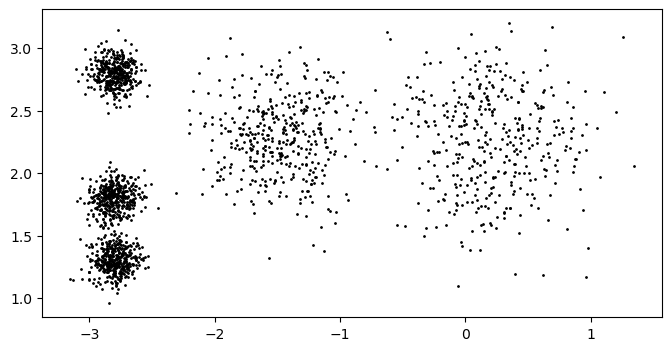

In [38]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    
plt.figure(figsize=(8, 4))
plot_data(X)
plt.show()

- How do we characterize a cluster?

- In k-Means, each cluster is represented by a point (let us call it the "center point" or "centroid"). The idea is simple: given 2 or more centroids, an observation in the dataset is assigned to the nearest centroid.

- So, two centroids divide the dataset into two clusters. Three centroids divide the dataset into three clusters, and so on.

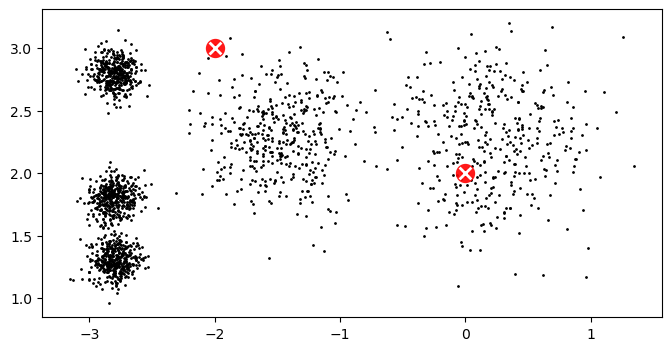

In [39]:
def plot_centroids(centroids, weights=None, circle_color='r', cross_color='w'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

centeroids = np.array(
    [[-2,  3],
     [ 0,  2]]
)    

plt.figure(figsize=(8, 4))
plot_data(X)
plot_centroids(centeroids)
plt.show()

- We need a little bit of coding to "automate" this division given a set of centroids.

In [40]:
mins = X.min(axis=0) - 0.1
maxs = X.max(axis=0) + 0.1
resolution = 1000
xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                     np.linspace(mins[1], maxs[1], resolution))

In [41]:
# finding distances to the first centroid
distances1 = np.linalg.norm(
    np.c_[xx.ravel(), yy.ravel()]-centeroids[0],
    axis=1
)
distances1[:5]

array([2.48141252, 2.47904043, 2.476675  , 2.47431625, 2.47196419])

In [42]:
# finding distances to the second centroid
distances2 = np.linalg.norm(
    np.c_[xx.ravel(), yy.ravel()]-centeroids[1],
    axis=1
)
distances2[:5]

array([3.44790093, 3.44346394, 3.43902767, 3.4345921 , 3.43015724])

In [43]:
distances = np.array([
    np.linalg.norm(np.c_[xx.ravel(), yy.ravel()]-centeroid,axis=1) 
    for centeroid in centeroids
])
distances

array([[2.48141252, 2.47904043, 2.476675  , ..., 3.44801365, 3.45269852,
        3.45738344],
       [3.44790093, 3.44346394, 3.43902767, ..., 1.93566195, 1.93915081,
        1.94264479]])

In [44]:
Z = np.argmin(distances, axis=0)
Z[:5], Z[-5:]

(array([0, 0, 0, 0, 0], dtype=int64), array([1, 1, 1, 1, 1], dtype=int64))

- Let us write a function to plot the clusters. In the below code, `Z`, which is the cluster of each point in the meshgrid, is calculated as outlined above.

In [45]:
def plot_clusters(X, centeroids):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    resolution = 1000
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = np.argmin(np.array([
        np.linalg.norm(np.c_[xx.ravel(), yy.ravel()]-centeroid,axis=1) 
        for centeroid in centeroids
    ]), axis=0)

    plt.figure(figsize=(8, 4))
    plot_data(X)
    plot_centroids(centeroids)
    Z = Z.reshape(xx.shape)
    plt.contourf(
        Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
        cmap="Pastel2"
    )
    plt.contour(
        Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
        linewidths=1, colors='k'
    )
    plt.show()

- Now, we can see that choosing two centroids divides the feature space into two regions.

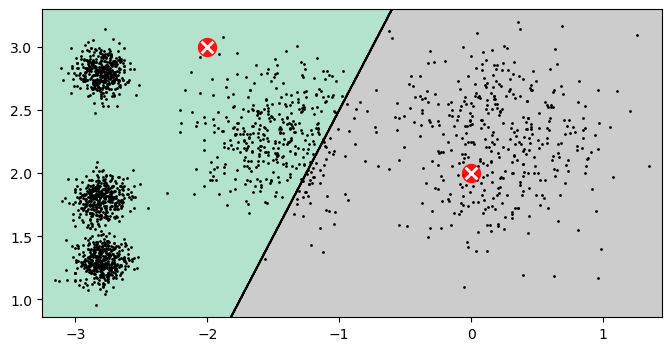

In [46]:
centeroids = np.array(
    [[-2,  3],
     [ 0,  2]]
)    
plot_clusters(X, centeroids)

- Choosing three centroids, divides the feature space into three regions.

- This type of plot is called a **Voronoi diagram**. It is a plot partitioning the space into regions based on which point in a given set of points it is closest to.

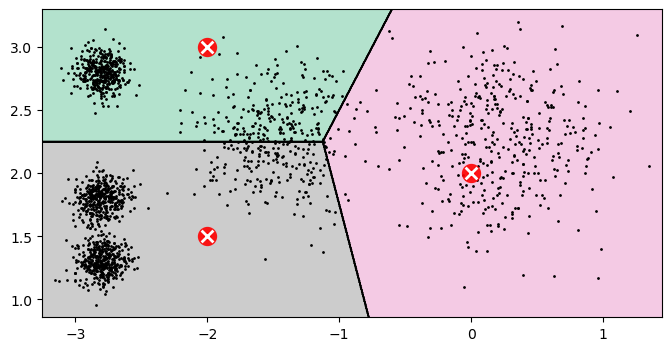

In [47]:
centeroids = np.array(
    [[-2,  3],
     [ 0,  2],
     [-2, 1.5]]
)
plot_clusters(X, centeroids)

- Okay, now we know how to quantify partitioning. For the above example, the following partitioning with 5 clusters looks best.

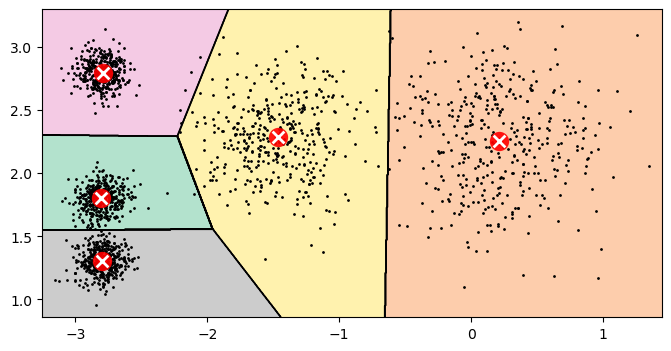

In [48]:
centeroids = np.array([
       [-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

plot_clusters(X, centeroids)

- But, how can we decide if a clustering is better than another? How do we measure the quality of a clustering?

- In k-Means, we measure the quality of a clustering by the sum of the distances of each observation from their associated center points. This number is called the **inertia** of the clustering.

- Let $\{\mathbf{X}_n\}_{n=1}^N$ be the observations and $\mathbf{c}_1,$ $\dots,$ $\mathbf{c}_k$ be $k$ center points. Let $S_i$ be the set of all the indices of observations assigned to center point $\mathbf{c}_i$. The inertia is:
    $$\begin{align*}
        I\left(\mathbf{c}_1,\dots,\mathbf{c}_k\right) = \sum_{i=1}^k \sum_{n\in S_i} \|\mathbf{X}_n - \mathbf{c}_{i}\|
    \end{align*}$$

- So, we have to make two decision:
    - How many clusters (that is the number $k$) to use?
    - Assuming $k$ clusters, which center points minimize the above cost function.

- We answer the first question later in Section 3. Let us concentrate on the second question. Find $k$ center points $\mathbf{c}_1,$ $\dots,$ $\mathbf{c}_k$ that minimize inertia

- It is best to start with  $k=1$, that is
    $$\begin{align*}
       \min_{\mathbf{c}} I\left(\mathbf{c}\right) = \sum_{n=1}^N \|\mathbf{X}_n - \mathbf{c}\|
    \end{align*}$$

- Can you guess the solution (here $\|\cdot\|$ is the Euclidean distance)?

- One can show that the optimizer $\mathbf{c}^*$ is the <strong>centroid</strong> (or the center of mass):
    $$\begin{align*}
       \mathbf{c}^*= \frac{1}{N}\sum_{n=1}^N \mathbf{X}_n
    \end{align*}$$

- Now, let $S_i$ be the indices associated with (an arbitrarily chosen) center point $\mathbf{c}_i$. Let $\mathbf{c}^*_i$ be the centroid of this cluster, that is $$\begin{align*}\mathbf{c}^*_i= \frac{1}{|S_i|}\sum_{n\in S_i} \mathbf{X}_n\end{align*}.$$ Here, $|S_i|$ is the number of elements of $S_i$

- By what we have just shown, we must have
    $$\begin{align*}
        \sum_{n\in S_i} \|\mathbf{X}_n - \mathbf{c}^*_{i}\| \le \sum_{n\in S_i} \|\mathbf{X}_n - \mathbf{c}_{i}\|
    \end{align*}$$

- This implies that
    $$\begin{align*}
        I\left(\mathbf{c}^*_1,\dots,\mathbf{c}^*_k\right) = \sum_{i=1}^k \sum_{n\in S_i} \|\mathbf{X}_n - \mathbf{c}^*_{i}\| \le \sum_{i=1}^k \sum_{n\in S_i} \|\mathbf{X}_n - \mathbf{c}_{i}\| = I\left(\mathbf{c}_1,\dots,\mathbf{c}_k\right)
    \end{align*}$$

- We then obtain the following important observation. Given an arbitrary clustering, we get a better clustering (i.e. smaller inertia) by replacing the center points with centroids of each cluster.


- This is the basis of k-Means clustering algorithm:
    - <strong>Step 0:</strong> Start with an initial choice of center points.
    - <strong>Step 1:</strong> Cluster the observation according to the distance to the current center points.
    - <strong>Step 2:</strong> Replace center points with the centroids of their cluster. Go to Step 1.
    - We repeat Steps 1 and 2 until there is not change in the center points.


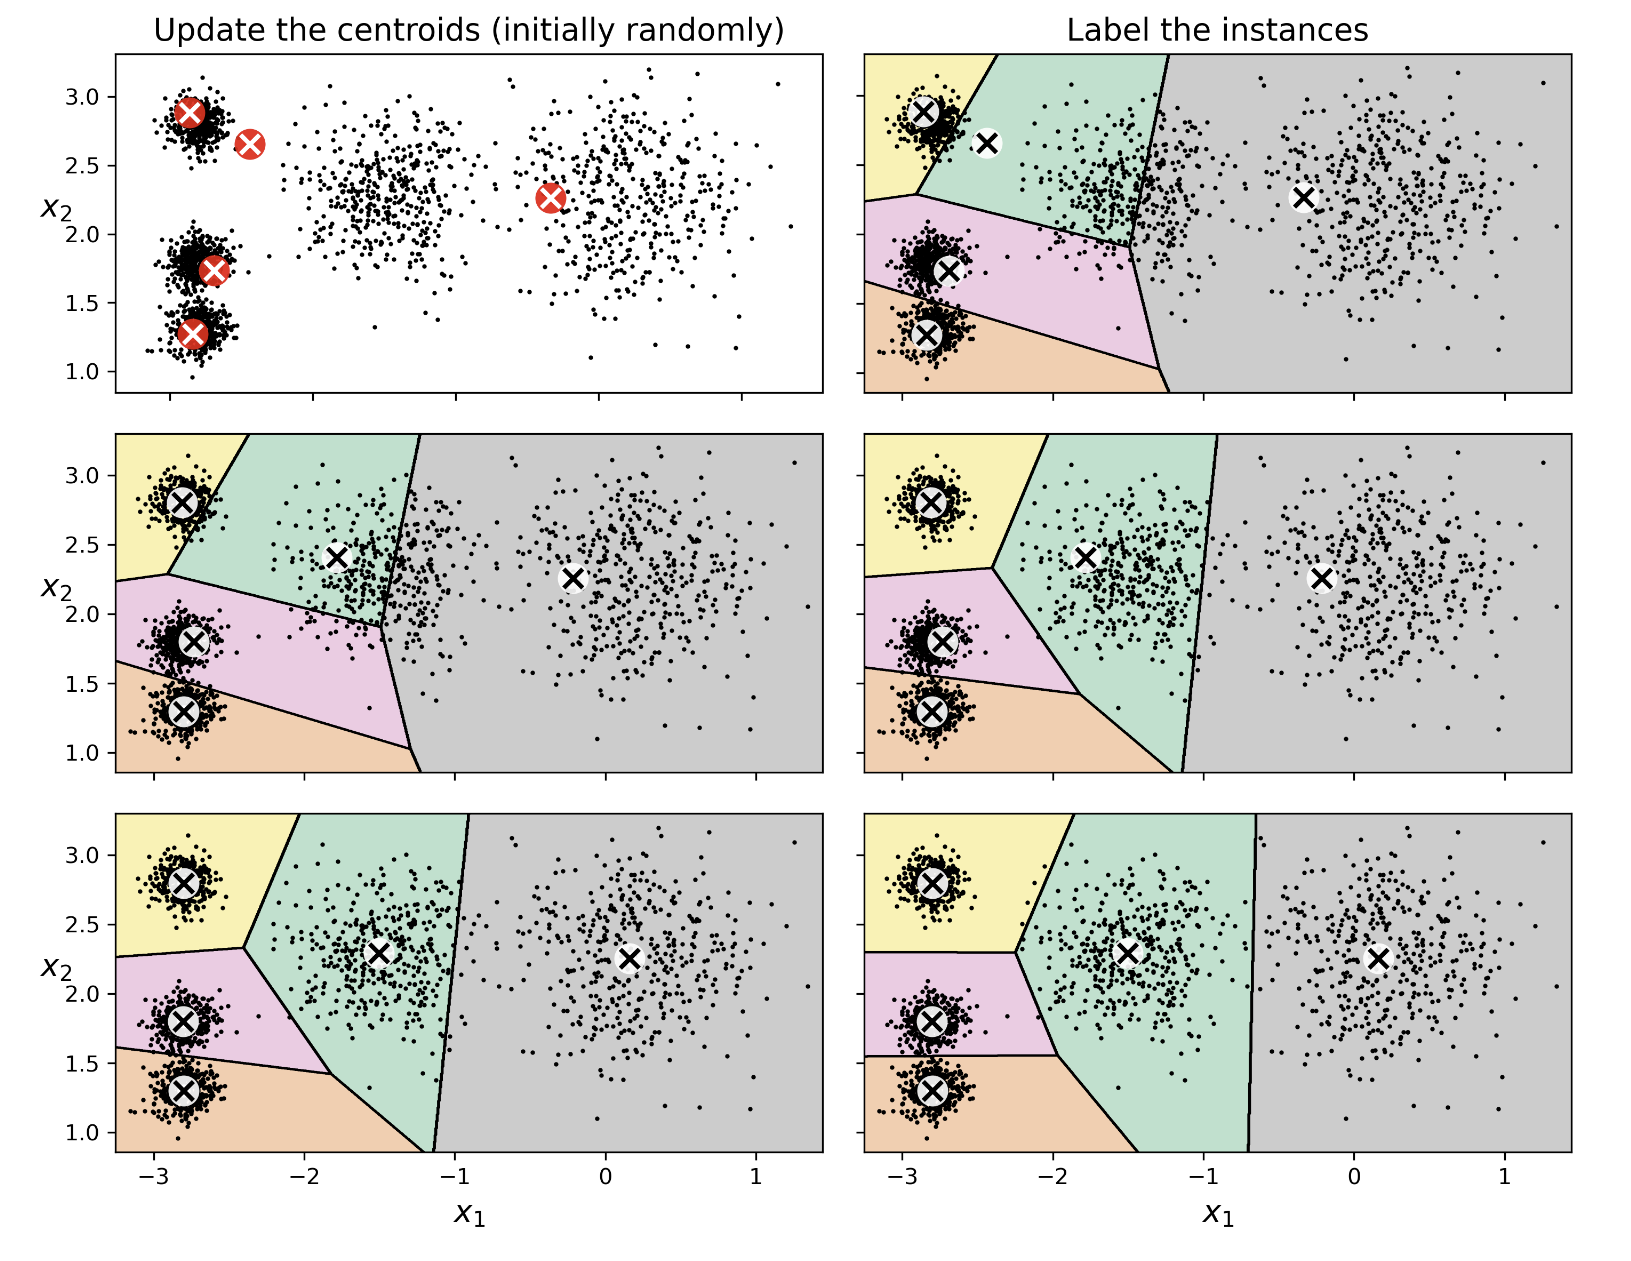

In [49]:
from IPython.display import Image
Image("Figs/kmeans_algorithm_plot.png",width=800)

- The k-Means algorithm is guaranteed to converge (i.e. it won't loop infinitely). Theoretically, it is only guaranteed to converge to a local minimum. The worst convergence rate is exponential.

- In practice, however, k-Means is the fastest clustering algorithm. Its complexity is linear with regards to sample size, number of features, and the number of clusters.

- The class `sklearn.cluster.KMeans` implements k-Means clustering.
    - - Note: you may need to update threadpoolctl by running `pip install -U threadpoolctl` in the Anaconda prompt

In [50]:
from sklearn.cluster import KMeans
kmc = KMeans(n_clusters=5, random_state=42)
kmc.fit(X)

KMeans(n_clusters=5, random_state=42)

- As in other sklearn predictors, you have a predict method that finds the cluster to which a new point belongs.

In [51]:
kmc.predict(np.array([[1,-3], [-1, 2.5]]))

array([0, 3])

- The cluster_centers_ property of a fitted KMeans instance stores the centroids. The minimum inertia is returned by `inertia_ property`. The score method calculates negative inertia on a given sample.

In [52]:
kmc.cluster_centers_

array([[-0.066884  ,  2.10378803],
       [-2.79290307,  2.79641063],
       [-2.80214068,  1.55162671],
       [-1.47468607,  2.28399066],
       [ 0.47042841,  2.41380533]])

In [53]:
kmc.inertia_

224.07433122515732

In [54]:
kmc.score(X)

-224.07433122515727

Let us re-write the function we used for getting Veronoi diagrams. This time, we use the `KMeans` class to find the optimal clusters.

In [55]:
def plot_kmc(X, k, random_state=42):
    kmc = KMeans(n_clusters=k, random_state=random_state)
    kmc.fit(X)
    centeroids = kmc.cluster_centers_
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    resolution = 1000
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = kmc.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(8, 4))
    plot_data(X)
    plot_centroids(centeroids)
    Z = Z.reshape(xx.shape)
    plt.contourf(
        Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
        cmap="Pastel2"
    )
    plt.contour(
        Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
        linewidths=1, colors='k'
    )
    plt.show()
    print("inertia = {}".format(kmc.inertia_))

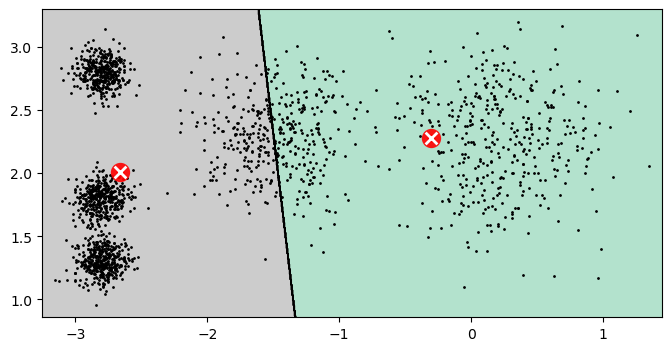

inertia = 1149.8913501507031


In [56]:
plot_kmc(X, 2)

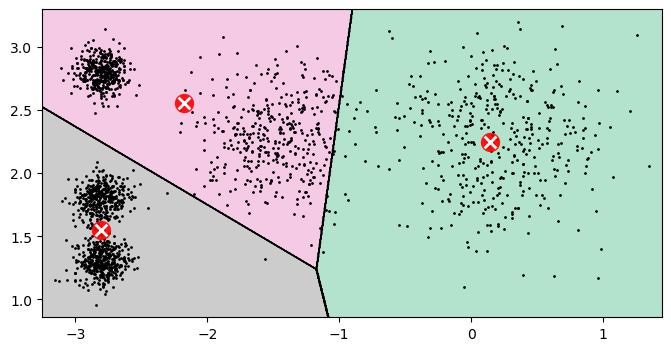

inertia = 653.2167190021554


In [57]:
plot_kmc(X, 3)

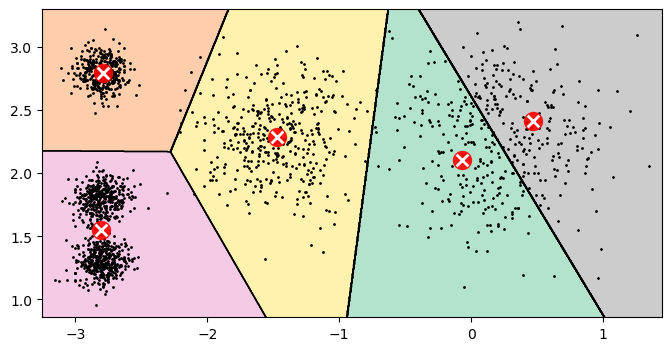

inertia = 224.07433122515732


In [58]:
plot_kmc(X, 5)

- Most points are correctly labled. Some on the boundary of the yellow and purple cluster are mislabled. This usually happens with k-Means when clusters have different size.

- Instead of assinging each observation to a single cluster (this is called **hard clustering**), we can use distance to a centroid as a "measure of affinity." In other words, we assign k numbers to each observation, the j-th number being the distance of the observation to the centroid of the j-th cluster. This is called **soft clustering**.

- You can use the transform method of a KMeans instance to perform soft-clustering.

In [59]:
# hard clustering
kmc.predict(np.array([[1,-3], [-1, 2.5]]))

array([0, 3])

In [60]:
# soft clustering
kmc.transform(np.array([[1,-3], [-1, 2.5]]))

array([[5.21410526, 6.92708379, 5.93073178, 5.8347775 , 5.43964468],
       [1.01375016, 1.81723985, 2.03644861, 0.52152363, 1.47295255]])

- Soft clustering can be used as a dimensionality reduction technique, assuming $k$ is (much) less than the number of features.

- Some further comments on the k-Means algorithm:
    - Since "distance measure" plays a central role in k-Means, **scaling features is very important**.

    - As we mentioned, the algorithm is only guaranteed to converge to a local optimum. To find the global optimum, one should start with a good initial point. There are various strategies to acheive this, including randomized initialization controlled by the `n_init` parameter.

    - Another method is to use the k-Means++ algorithm where the first centroid is chosen at a random observation, and each successive centroid is chosen at another observation with probability proportional to the distance to the closest centroid. This spreads out the centroids and is shown to perform better. This is the default behavior.

    - The `KMeans` class by default also implements an accelrated version of the k-Means algorithm using that avoid unnecessary distance calculations.

    - There is a `MiniBatchKMeans` class that uses mini-batches of the training data for fiting k-Means. This can be very useful for large datasets. See the textbook for further details.

# 3. Choosing the number of k-Means clusters

- We haven't addressed one issue yet. How should we decide on the number of clusters?

- As the following plots indicate, we can "underestimate" or "overestimate" the number of clusters.

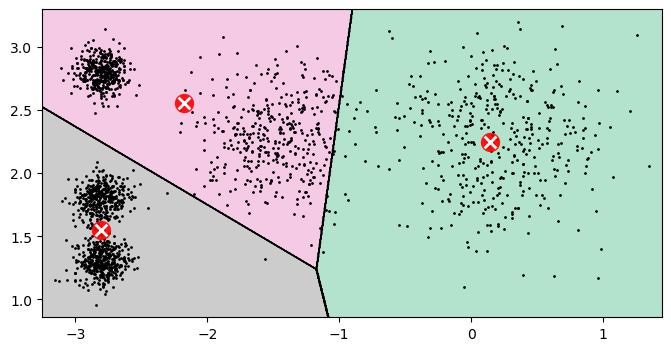

inertia = 653.2167190021554


In [61]:
plot_kmc(X, 3)

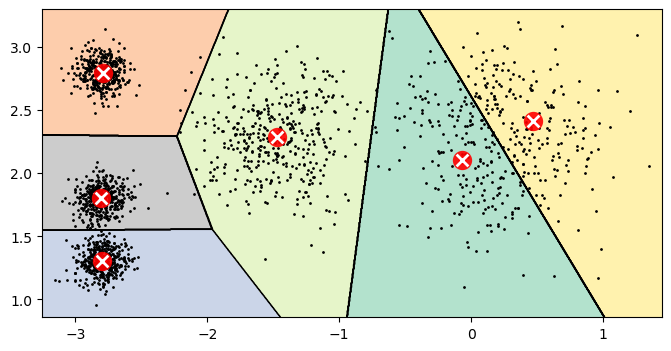

inertia = 173.87609062637867


In [62]:
plot_kmc(X, 6)

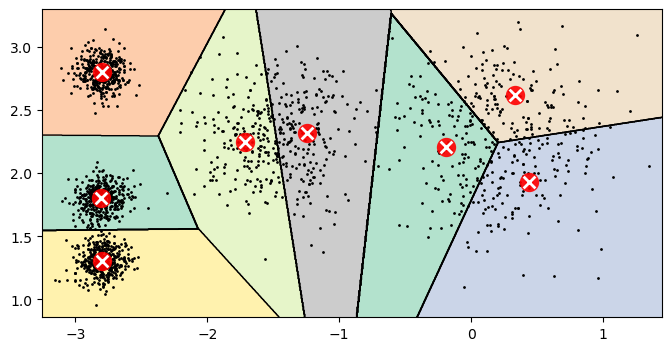

inertia = 127.13141880461836


In [63]:
plot_kmc(X, 8)

- As you probably noticed, inertia is not a good measure for choosing $k$. It always decreases as $k$ increases.

- One way to choose $k$, is to plot inertia against the number of clusters. First, we calculate inertias for different $k$:

In [64]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
             for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

- The plot of inertia vs $k$ is shown below. It is a decreasing function, as expected.

- You should be looking for the "elbow", that is roughly the value $k^∗$ such that the inertia is decreasing at a high rate on the left of $k^∗$ compared to the right.

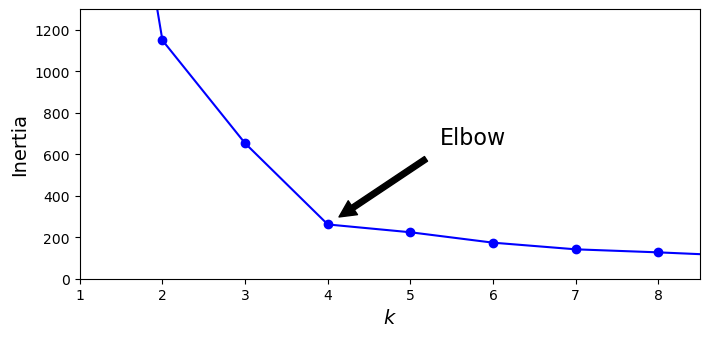

In [65]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

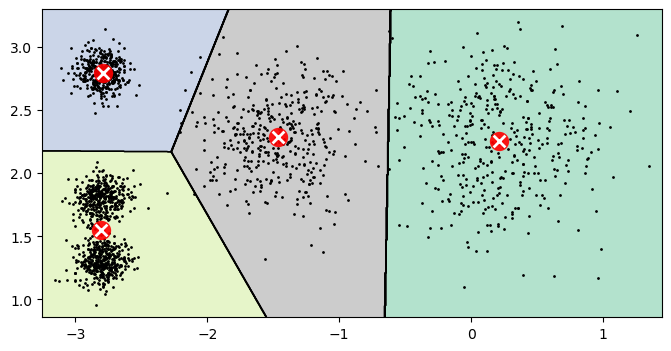

inertia = 261.796777856947


In [66]:
plot_kmc(X, 4)

- Another approach for choosing the number of clusters is to use <strong>silhouette coefficients</strong>.

- The silhouette coefficients of an observation $\mathbf{X}_i$ (with respecto to a clustering) is
    $$\begin{align*}
        \frac{b_i-a_i}{\max\{a_i,b_i\}}\in [-1, 1]
    \end{align*}$$

-​ $a_i$ is the "mean intra-cluster distance". In other words, let $\mathbf{X}_i$ be in cluster $S_j$. Then,
    $$\begin{align*}
        a_i= \frac{1}{|S_i|-1}\sum_{n\in S_i} \|\mathbf{X}_n - \mathbf{X}_i\|
    \end{align*}$$

- As before, $|S_i|$ is the number of elements of $S_i$.

- $b_i$ is the "mean nearest-cluster distance". Specifically, for each clusters not containing $\mathbf{X}_i$, denoted by $S_\ell$ for $\ell\ne j$, define the "extra-cluster distance"
    $$\begin{align*}
        d_\ell= \frac{1}{|S_\ell|}\sum_{n\in S_\ell} \|\mathbf{X}_n - \mathbf{X}_i\|
    \end{align*}$$

- Then, $\displaystyle b_i = \min_\ell d_\ell$.

- Silhouette coefficients of $\mathbf{X}_i$ is interpreted as follows:
    - $b_i \gg a_i$: $\mathbf{X}_i$ is much closer to observations in its cluster than the ones outside its cluster. The clustering algorithm has done a <strong>good</strong> job (on $\mathbf{X}_i$). The silhouette coefficients is near its maximum 1.
    - $b_i \ll a_i$: this means that $\mathbf{X}_i$ is much closer to points outside its cluster than the one inside. In this case, the clustering algorithm has done a <strong>bad</strong> job in clustering $\mathbf{X}_i$ (it is assinged to a wrong cluster). In this case, the silhouette coefficients is near its minimum -1.
    - $b_i \approx a_i$: $\mathbf{X}_i$ is almost as close to points in its cluster as to the points in its nearest cluster. This indicates that $\mathbf{X}_i$ is on the boundary of a cluster. In this case, the silhouette coefficients is near 0.

- We can use the silhouette coefficients in two ways to decide on the number of cluster.

- Firstly, we can use **silhouette scores** which are the average of the silhouette coefficients of all observations. This score can be claculated using sklearn.metrics.silhouette_score function.
​


In [67]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmc.labels_)

0.6267891051050735

- Then, we can plot silhouette scores against  $k$ and choose  $k$ that maximizes the score. As the plot below indicates,  $k=4$ is again chosen, although  $k=5$ is a second best choice.

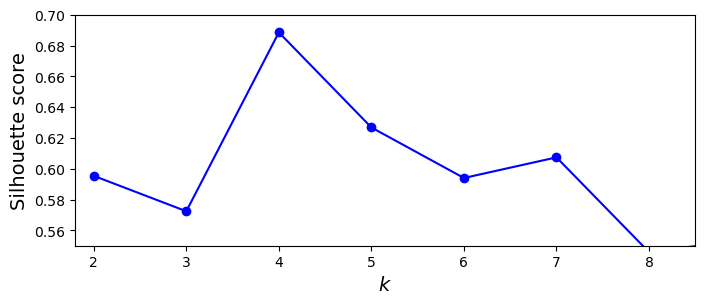

In [68]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()


- The second way to use silhouette coefficients is to use a **silhouette diagram**. This is a plot of the silhouette coefficients of all the observations in which the observations are sorted as follows.

- Firstly, observations are grouped according to their clusters. Secondly, within each cluster, observations are ordered according to their silhouette coefficients.

- The silhouette diagram allows us to give a visual display of the quality of each cluster regardless of the dimensionality of the data, and regardless of the clustering algorithm.

- Below, we show the **silhouette diagram** for $k=3,...,6$. Note that you can use `sklearn.metrics.silhouette_samples` to obtain silhouette coefficients.

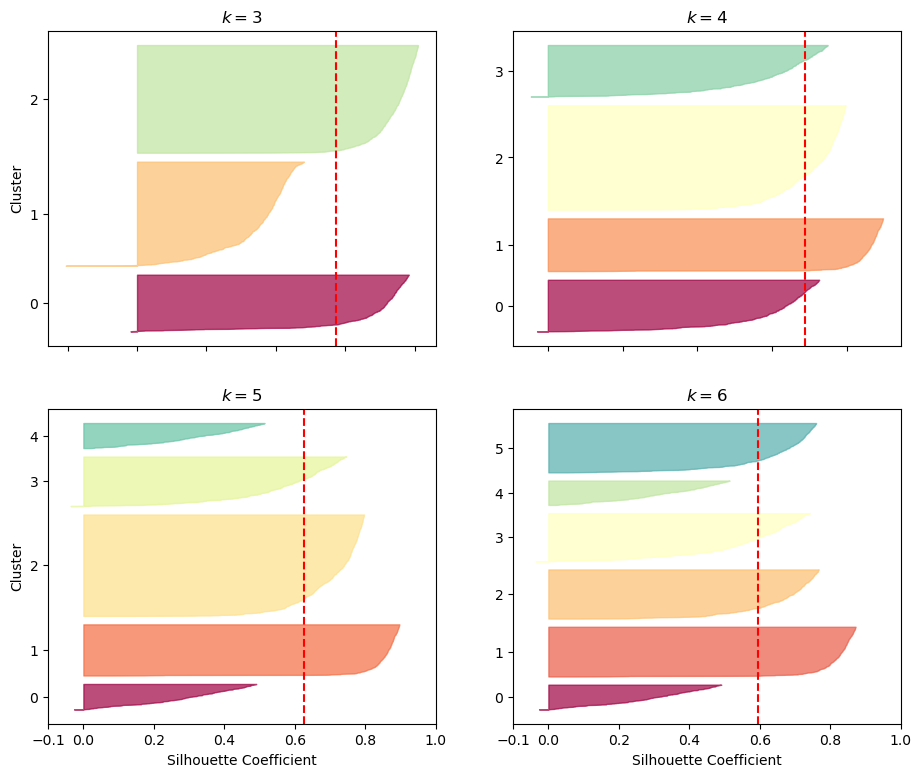

In [69]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")
plt.show()

- The silhouette scores are shown by the vertical dashed lines. A "bad" cluster is a cluster with low silhouette coefficients (for example, clusters completely to the left of the dashed line) since this means its instances are much too close to other clusters or clusters that should be seperate have been fused together. Clearly, $k=3$ and $k=6$ include bad clusters. $k=4$ and $k=5$ do not have bad clusters.

- You should secondarily aim for uniformity in clusters. In this sense, $k=5$ maybe a bit better than $k=4$. The upper cluster for $k=4$ has much higher silhouette coeffiencts than the rest. Note, however, you should avoid cases where all clusters are uniformly bad.

- These silhouette methods can be used with any clustering method, not just k-Means.